In [1]:
from google.colab import files
upload=files.upload()

Saving ToyotaCorolla - MLR.csv to ToyotaCorolla - MLR.csv


In [2]:
# Neccesary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm


In [3]:
# Loading dataset
df = pd.read_csv("ToyotaCorolla - MLR.csv")
df.head()

,Price,Age_08_04,KM,Fuel_Type,HP,Automatic,cc,Doors,Cylinders,Gears,Weight
0,13500,23,46986,Diesel,90,0,2000,3,4,5,1165
1,13750,23,72937,Diesel,90,0,2000,3,4,5,1165
2,13950,24,41711,Diesel,90,0,2000,3,4,5,1165
3,14950,26,48000,Diesel,90,0,2000,3,4,5,1165
4,13750,30,38500,Diesel,90,0,2000,3,4,5,1170


In [4]:
# Renaming for convenience
df.rename(columns={
    'Age_08_04': 'Age',
    'cc': 'CC',
    'Fuel_Type': 'FuelType'
}, inplace=True)

In [5]:
# Dropping non-informative column
df.drop(['Cylinders'], axis=1, inplace=True)

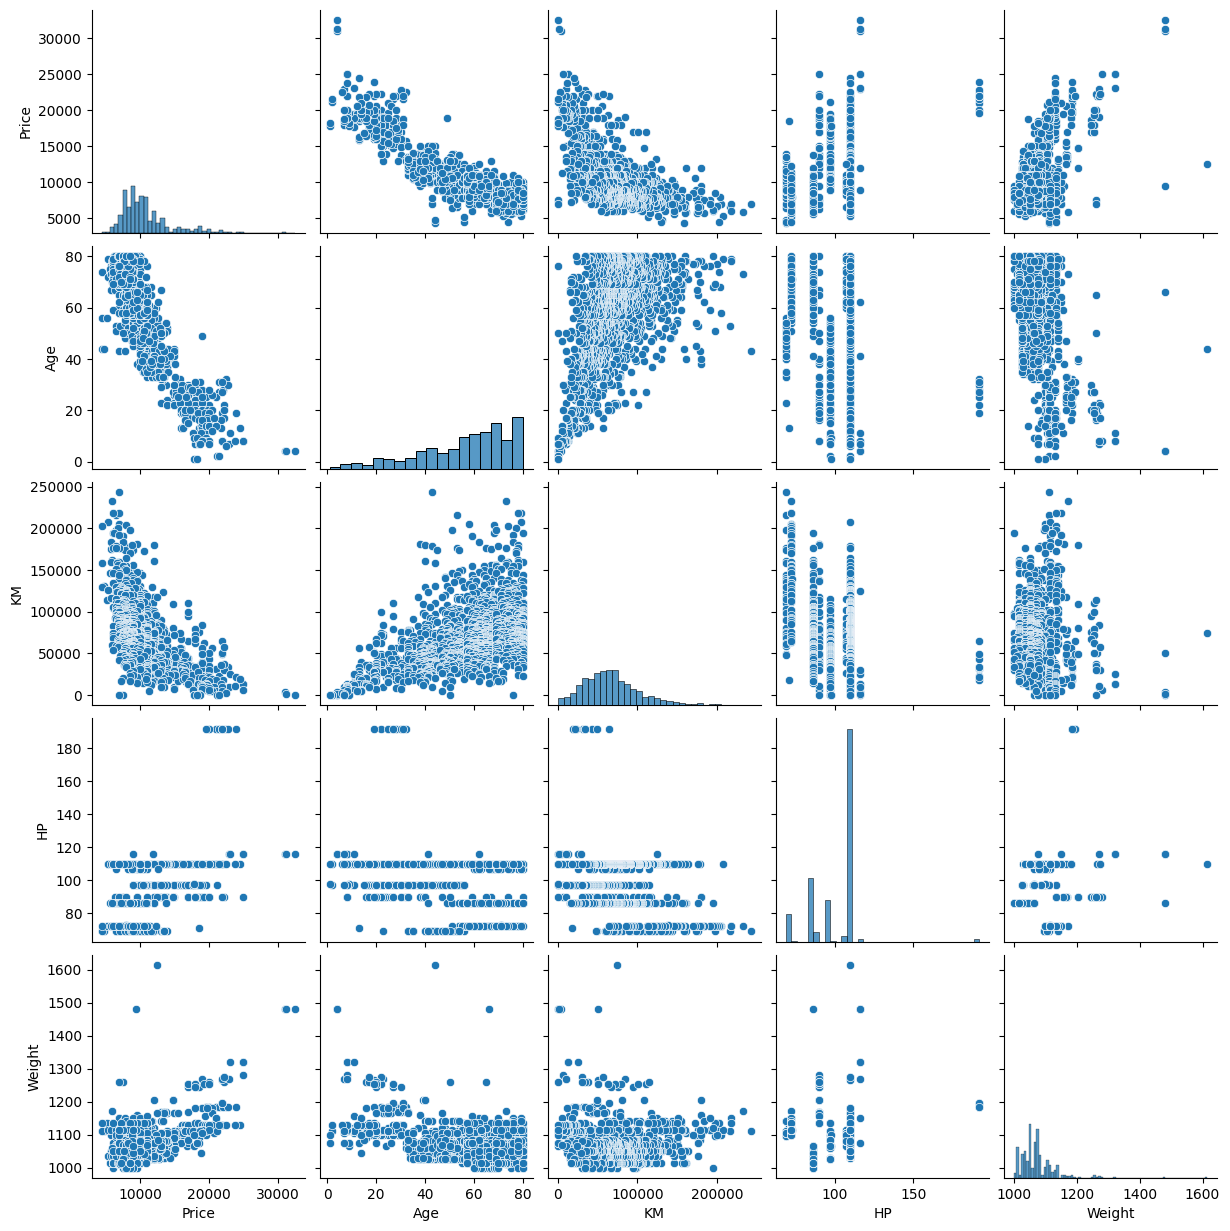

In [6]:
#Visualizations
sns.pairplot(df[['Price', 'Age', 'KM', 'HP', 'Weight', 'FuelType']])
plt.show()

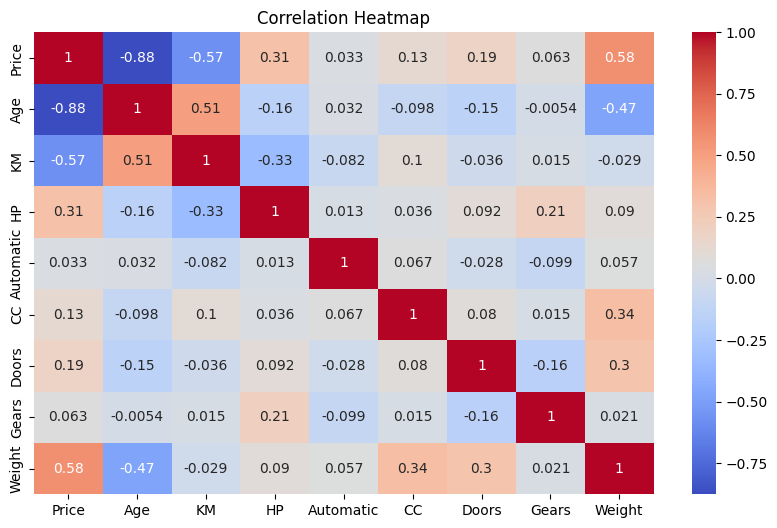

In [7]:
# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


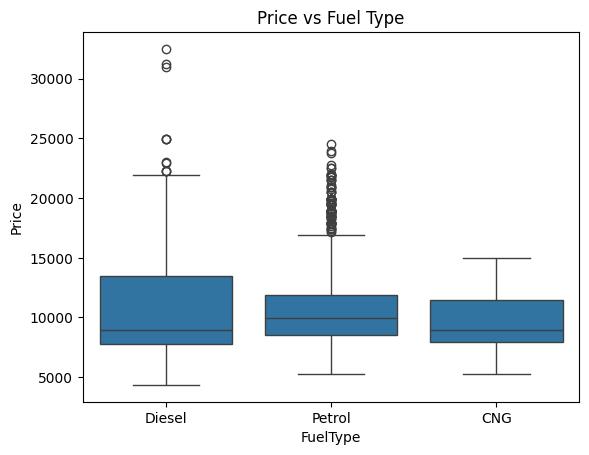

In [8]:
# Boxplot
sns.boxplot(x='FuelType', y='Price', data=df)
plt.title("Price vs Fuel Type")
plt.show()


In [9]:
# Feature-target split
X_raw = df[['Age', 'KM', 'FuelType', 'HP', 'Automatic', 'CC', 'Doors', 'Gears', 'Weight']]
y = df['Price']

In [10]:
# One-hot encoding
categorical = ['FuelType']
ct = ColumnTransformer(transformers=[
    ('encoder', OneHotEncoder(drop='first'), categorical)
], remainder='passthrough')
X = ct.fit_transform(X_raw)


In [11]:
# Train-test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Model 1: Linear Regression with all features
model1 = LinearRegression().fit(X_train, y_train)


In [13]:
# Model 2: Linear Regression with top features (based on EDA/correlation)
top_feature_indices = [-1, -3, -4]  # Weight, HP, KM
X_train_sub = X_train[:, top_feature_indices]
X_test_sub = X_test[:, top_feature_indices]
model2 = LinearRegression().fit(X_train_sub, y_train)


In [14]:
# Model 3: OLS Regression (for coefficient summary)
X_train_sm = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_sm).fit()
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     762.7
Date:                Sun, 06 Jul 2025   Prob (F-statistic):               0.00
Time:                        11:25:57   Log-Likelihood:                -9863.2
No. Observations:                1148   AIC:                         1.975e+04
Df Residuals:                    1137   BIC:                         1.980e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.426e+04   1751.390     -8.139      0.0

In [15]:
# Evaluation function
def evaluate(model, X_test, y_test, label):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{label} - RMSE: {rmse:.2f}, R2: {r2:.2f}")
    # Visualization: Actual vs Predicted
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(f"{label} - Actual vs Predicted")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
    plt.show()
    # Residual plot
    residuals = y_test - y_pred
    plt.figure(figsize=(6,4))
    sns.histplot(residuals, kde=True, bins=30)
    plt.title(f"{label} - Residual Distribution")
    plt.xlabel("Residuals")
    plt.show()


Model 1 (All Features) - RMSE: 1484.27, R2: 0.83


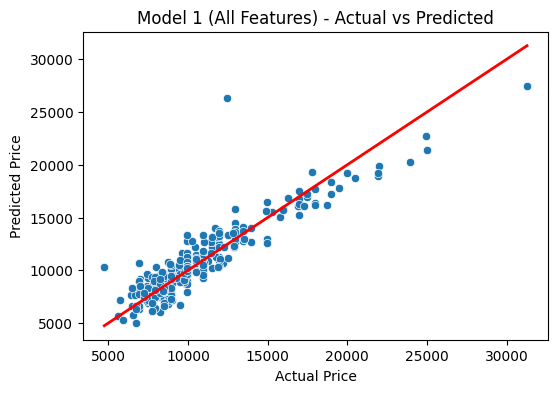

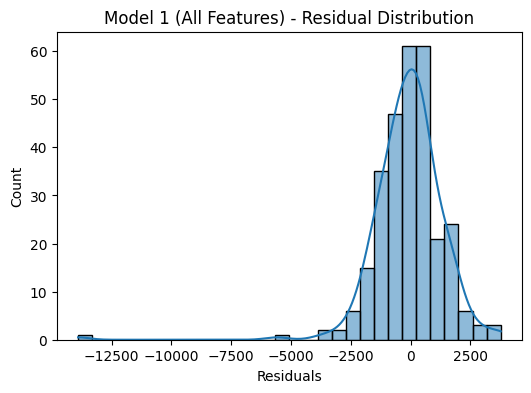

Model 2 (Top Features) - RMSE: 2976.37, R2: 0.34


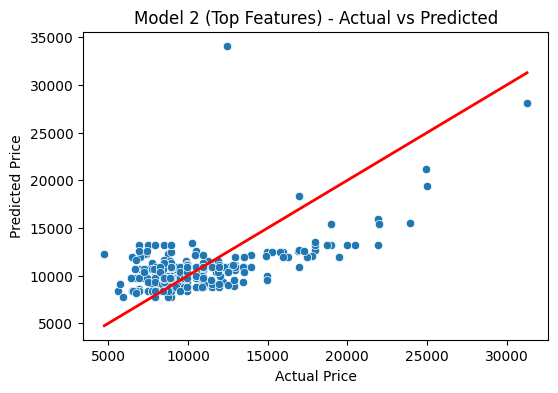

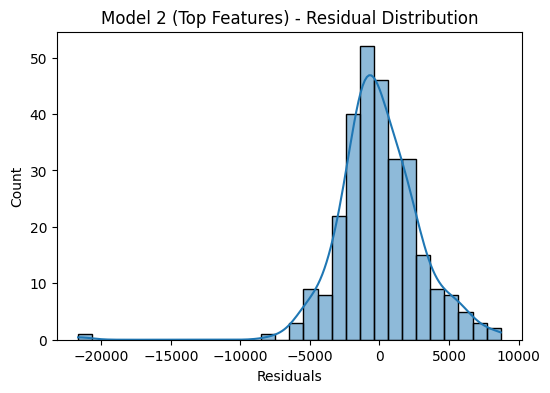

In [16]:
# Evaluate models
evaluate(model1, X_test, y_test, "Model 1 (All Features)")
evaluate(model2, X_test_sub, y_test, "Model 2 (Top Features)")

Ridge Regression - RMSE: 1483.15, R2: 0.84


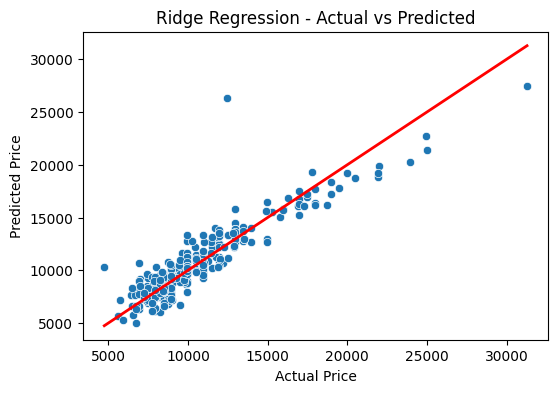

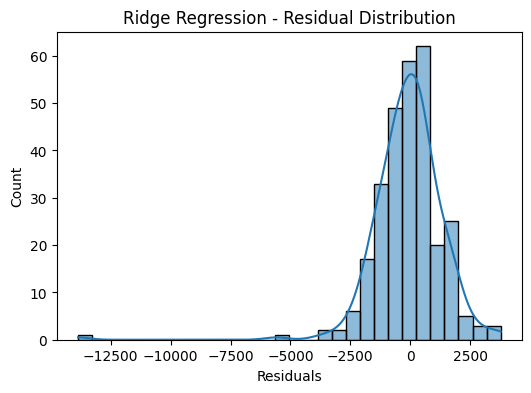

In [17]:
# Ridge Regression
ridge = Ridge(alpha=1.0).fit(X_train, y_train)
evaluate(ridge, X_test, y_test, "Ridge Regression")

Lasso Regression - RMSE: 1481.68, R2: 0.84


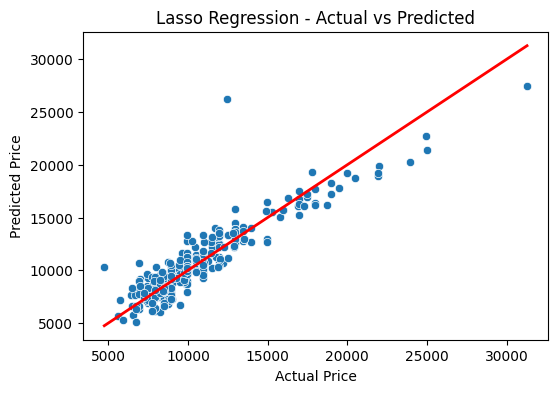

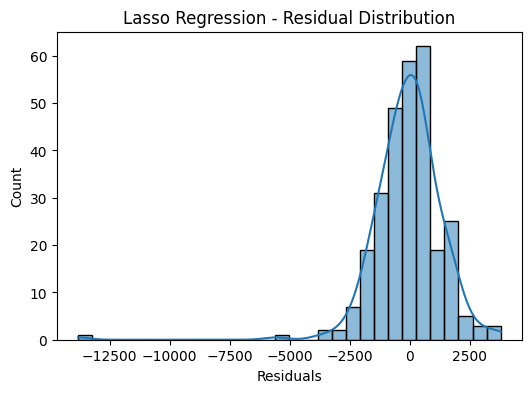

In [18]:
# Lasso Regression
lasso = Lasso(alpha=1.0).fit(X_train, y_train)
evaluate(lasso, X_test, y_test, "Lasso Regression")

In [19]:
# Cross-validation function
def cross_validate_model(model, X, y, label):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, scoring='r2', cv=kf)
    print(f"{label} - 5-Fold Cross-Validation R²: Mean={scores.mean():.2f}, Std={scores.std():.2f}")

In [20]:
# Cross-Validation for all models
cross_validate_model(model1, X, y, "Model 1 (All Features)")
cross_validate_model(model2, X[:, top_feature_indices], y, "Model 2 (Top Features)")
cross_validate_model(ridge, X, y, "Ridge Regression")
cross_validate_model(lasso, X, y, "Lasso Regression")


Model 1 (All Features) - 5-Fold Cross-Validation R²: Mean=0.65, Std=0.40
Model 2 (Top Features) - 5-Fold Cross-Validation R²: Mean=-0.05, Std=0.74
Ridge Regression - 5-Fold Cross-Validation R²: Mean=0.69, Std=0.32
Lasso Regression - 5-Fold Cross-Validation R²: Mean=0.67, Std=0.37


Model Fit
R-squared = 0.870 and Adjusted R-squared = 0.869

The model explains 87% of the variation in car prices — an excellent fit.

The adjusted R² is almost the same, suggesting that most of the features are useful.

Statistical Significance
F-statistic = 762.7, p-value = 0.00

Indicates that the overall regression model is highly statistically significant.

Coefficient Interpretation
Variables like x2, x3, x4, x5, x9, and x10 have p-values < 0.05, so they are statistically significant predictors of price.

Variables x1, x6, x7, and x8 are not significant (p > 0.05); they may be considered for removal or further investigation.

Model Comparison (Test Set Performance)

| Model                  | RMSE    | R²   | Comments                                                                    |
| ---------------------- | ------- | ---- | --------------------------------------------------------------------------- |
| Model 1 (All features) | 1484.27 | 0.83 | Performs very well on test data.                                            |
| Model 2 (Top features) | 2976.37 | 0.34 | **Significant performance drop** — important predictors likely removed.     |
| Ridge Regression       | 1483.15 | 0.84 | Slight improvement over OLS, helps reduce overfitting.                      |
| Lasso Regression       | 1481.68 | 0.84 | Best performer — also helps in feature selection by shrinking coefficients. |

Cross-Validation Results

| Model                  | Mean R² | Std Dev | Comments                                                                                   |
| ---------------------- | ------- | ------- | ------------------------------------------------------------------------------------------ |
| Model 1 (All features) | 0.65    | 0.40    | Good average score but high variance — suggests **inconsistent performance** across folds. |
| Model 2 (Top features) | -0.05   | 0.74    | **Very poor performance** — potentially underfitting.                                      |
| Ridge Regression       | 0.69    | 0.32    | **Stable and improved** performance. Regularization is effective.                          |
| Lasso Regression       | 0.67    | 0.37    | Similar to Ridge — balances bias and variance well.                                        |

Conclusion:-

Model 1 (All features) performs well but shows signs of multicollinearity and high variance in cross-validation.

Model 2 (Top features) underfits badly. Likely dropped important variables.

Ridge and Lasso offer comparable or better test performance, with better generalization based on cross-validation.

Lasso slightly edges out others in test RMSE and can help with feature selection due to coefficient shrinkage.

